## Imports

In [1]:
import os
import re
import sys
import typing
import gc


sys.path.append(
    os.path.join('.','src')
)

from src.models import Pipeline

In [2]:
pipeline = Pipeline('CONFIG_MODEL.json')

Selected optimization level O1:  Insert automatic casts around Pytorch functions and Tensor methods.

Defaults for this optimization level are:
enabled                : True
opt_level              : O1
cast_model_type        : None
patch_torch_functions  : True
keep_batchnorm_fp32    : None
master_weights         : None
loss_scale             : dynamic
Processing user overrides (additional kwargs that are not None)...
After processing overrides, optimization options are:
enabled                : True
opt_level              : O1
cast_model_type        : None
patch_torch_functions  : True
keep_batchnorm_fp32    : None
master_weights         : None
loss_scale             : dynamic


In [3]:
pipeline.model

NextWordPredictorModel(
  (embedding_layer): Embedding(10000, 256, padding_idx=0)
  (rnn): GRU(256, 200, num_layers=2, batch_first=True, dropout=0.5)
  (linear): Linear(in_features=200, out_features=10000, bias=True)
  (criterion): CrossEntropyLoss()
)

  0%|          | 8/7100 [00:00<01:31, 77.63it/s]

Train loss at epoch 0 : 9.209243914375843
Eval loss at epoch 0 : 9.209652099820131
updating best metric


  0%|          | 0/7100 [00:00<?, ?it/s]

Train loss at epoch 1 : 6.174411716595502
Eval loss at epoch 1 : 5.703722846442164
updating best metric


 15%|█▌        | 1066/7100 [00:08<00:45, 131.97it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 524288.0


 48%|████▊     | 3390/7100 [00:25<00:27, 133.21it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 524288.0


 79%|███████▊  | 5588/7100 [00:42<00:11, 132.72it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 524288.0


  0%|          | 0/7100 [00:00<?, ?it/s]

Train loss at epoch 2 : 5.527170700153834
Eval loss at epoch 2 : 5.513788282541939
updating best metric


 12%|█▏        | 832/7100 [00:06<00:47, 132.18it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 524288.0


 46%|████▌     | 3242/7100 [00:24<00:28, 133.13it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 524288.0


 75%|███████▌  | 5347/7100 [00:40<00:13, 128.77it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 524288.0


  0%|          | 0/7100 [00:00<?, ?it/s]

Train loss at epoch 3 : 5.278839957814821
Eval loss at epoch 3 : 5.450446317867679
updating best metric


  5%|▌         | 372/7100 [00:02<00:51, 129.85it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 524288.0


 34%|███▎      | 2386/7100 [00:18<00:36, 128.06it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 524288.0


 65%|██████▍   | 4595/7100 [00:34<00:18, 131.84it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 524288.0


  0%|          | 12/7100 [00:00<01:02, 113.86it/s]

Train loss at epoch 4 : 5.127588445838069
Eval loss at epoch 4 : 5.4268180019947705
updating best metric


  2%|▏         | 110/7100 [00:00<00:53, 131.76it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 524288.0


 37%|███▋      | 2595/7100 [00:20<00:36, 124.21it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 524288.0


 68%|██████▊   | 4805/7100 [00:36<00:17, 132.70it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 524288.0


 98%|█████████▊| 6961/7100 [00:53<00:01, 131.98it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 524288.0


100%|██████████| 724/724 [00:01<00:00, 417.47it/s]


Train loss at epoch 5 : 5.016937662782803
Eval loss at epoch 5 : 5.413711587039146
updating best metric


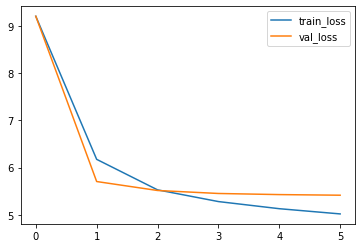

In [4]:
pipeline.train_model()

In [5]:
pipeline.evaluate()

100%|██████████| 6531/6531 [00:08<00:00, 750.13it/s]


5.410678762404665

In [6]:
pipeline.generate(start_text = 'when')

'when they disbanded much of the domestic — were done for the investment aired on july superman escape in the united states through the the bus for a position just when care came to study the year church with the scientology business foundation called it a local bird with a soccer update by sought out of the fort independent and a landmark later residence of around borders and then fortifications in the tower itself with the fish and the building avenue department for the city s capital on the canal but little miles from its cathedral the th century paintings from'

In [11]:
pipeline.model

NextWordPredictorModel(
  (embedding_layer): Embedding(10000, 256, padding_idx=0)
  (rnn): GRU(256, 200, num_layers=2, batch_first=True, dropout=0.5)
  (linear): Linear(in_features=200, out_features=10000, bias=True)
  (criterion): CrossEntropyLoss()
)

In [20]:
pipeline.model.rnn.state_dict() ++ pipeline.model.linear.state_dict()

TypeError: bad operand type for unary +: 'collections.OrderedDict'

In [21]:
pipeline.model.linear.state_dict()['weight']

tensor([[ 0.0920, -0.3084,  0.0071,  ..., -0.1118,  0.2542, -0.1783],
        [ 0.0453, -0.2914, -0.1204,  ..., -0.1137,  0.3070, -0.1746],
        [ 0.0864, -0.1459, -0.0077,  ..., -0.0059, -0.0561,  0.0088],
        ...,
        [ 0.2158, -0.2601, -0.2930,  ...,  0.2634, -0.0085,  0.1097],
        [ 0.2740, -0.1428,  0.1697,  ...,  0.2707,  0.0208,  0.0931],
        [ 0.0315, -0.1839,  0.0440,  ...,  0.1020, -0.0595,  0.2213]],
       device='cuda:0')

In [18]:
pipeline.model.criterion.state_dict()

OrderedDict()

In [8]:
assert False

AssertionError: 

In [ ]:
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import torch
from torchtext.datasets import WikiText2
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator

In [ ]:
import nltk

# from nltk.tokenize import TweetTokenizer
from nltk.tokenize import sent_tokenize

## Global Variables & Hyperparameters

In [ ]:
DEVICE = "cuda:0"
assert torch.cuda.is_available()
from apex import amp, optimizers

MIN_SEQ_LEN = 2
MAX_SEQ_LEN = 20

RNN_TYPE = 'LSTM'
BATCH_SIZE = 16
NUM_RNN_LAYERS = 4
EMB_SIZE = 256
HIDDEN_STATE_SIZE = 200
DROPOUT = 0.5
fp16 = True
POS_ENCODING = False
STARTING_LR = 5e-4
LAMBDA = 0
p = 1

val_split = 0.2
test_split = 0.1

# for reproducibility
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"
torch.manual_seed(0)
np.random.seed(23)

## Vocabulary

In [ ]:
train_iter = WikiText2(split='train')
tokenizer = get_tokenizer('basic_english')

train_text = ' '.join(train_iter)

In [ ]:
vocabulary = FromRawTextVocabulary(
    text = train_text,
    tokenizer = tokenizer,
    text_cleaner = None,
    max_voc_size = 10000,
    min_word_occ = 10
)

## Dataset

In [ ]:
train_iter, val_iter, test_iter = WikiText2()

train_text = ' '.join(train_iter)
val_text = ' '.join(val_iter)
test_text = ' '.join(test_iter)

train_dataset = SequenceDataset(
    vocabulary = vocabulary,
    text = train_text,
    max_seq_length = MAX_SEQ_LEN + 1,
    min_seq_length = MIN_SEQ_LEN,
    device = DEVICE
)
val_dataset = SequenceDataset(
    vocabulary = vocabulary,
    text = val_text,
    max_seq_length = MAX_SEQ_LEN + 1,
    min_seq_length = MIN_SEQ_LEN,
    device = DEVICE
)
test_dataset = SequenceDataset(
    vocabulary = vocabulary,
    text = test_text,
    max_seq_length = MAX_SEQ_LEN + 1,
    min_seq_length = MIN_SEQ_LEN,
    device = DEVICE
)

del train_text
del val_text
del test_text

gc.collect()

In [ ]:
train_dataloader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size = BATCH_SIZE,
    shuffle = True,
    pin_memory = False,
    drop_last = True
)
val_dataloader = torch.utils.data.DataLoader(
    val_dataset,
    batch_size = BATCH_SIZE,
    shuffle = False,
    pin_memory = False,
    drop_last = True
)
test_dataloader = torch.utils.data.DataLoader(
    test_dataset,
    batch_size = 2,
    shuffle = False,
    pin_memory = False,
    drop_last = True
)

In [ ]:
def map_weights(weights, m_ = 0.01, M_ = 1):
    weights = 1 / weights
    M, m = max(weights), min(weights)
    return (np.array(weights) - m) * (M_ - m_) / (M - m) + m_

weights = map_weights(np.array(list(vocabulary.vocab.values())))
weights = None

## Model

In [ ]:
model = NextWordPredictorModel(
    type_of_rnn = RNN_TYPE,
    emb_dim  = EMB_SIZE,
    vocab_size = vocabulary.get_vocab_size(),
    num_rnn_hidden_layers = NUM_RNN_LAYERS,
    hidden_state_size = HIDDEN_STATE_SIZE,
    dropout = DROPOUT,
    device = DEVICE,
    weight = weights,
    positional_encoding = POS_ENCODING
).to(DEVICE)

# need to setup the optimizer there because of the amp initialization
model.optimizer = torch.optim.Adam(model.parameters(), lr = STARTING_LR)

if fp16:
    model, model.optimizer = amp.initialize(
        model,
        model.optimizer,
        opt_level = 'O1' # https://nvidia.github.io/apex/amp.html
    )

model.scheduler = torch.optim.lr_scheduler.StepLR(model.optimizer, 1.0, gamma=0.97)

## Training

In [ ]:
metrics = model.fit(
    train_dataloader = train_dataloader,
    eval_dataloader = val_dataloader,
    num_epochs = 20,
    fp16 = fp16,
    p = p,
    lambda_ = LAMBDA,
    early_stopping = True,
    early_stopping_patience = 2,
    early_stopping_metric = 'val_loss',
    early_stopping_metric_best = 'min', # if lower is better (like for loss)
)

In [ ]:
df = pd.DataFrame(metrics).T
plt.figure()
plt.plot(df['train_loss'])
plt.plot(df['val_loss'])
plt.legend(['train_loss', 'val_loss'])
plt.show()

## Testing

In [ ]:
sent = 'Historians write in the context of their own time and with due regard to the current dominant ideas of how to interpret the past'
ind = [train_dataset.get_idx(w.lower()) for w in sent.split(' ')]
print(ind)
hidden = model.init_hidden(1)
inputs = torch.tensor([ind]).to(DEVICE)
model.eval()
output, _ = model(inputs, hidden)
preds = output.view(-1, model.vocab_size)

In [ ]:
for top4 in preds.topk(3).indices:
    res = []
    for l in top4:
        w = vocabulary.idx_to_word[l.item()]
        res.append(w)
    print(res)

In [ ]:
model.count_params()

In [ ]:
model.evaluate(test_dataloader)

### quick results

test set loss
==========

EPOCH = 5

Basis
--------

RNN_TYPE = 'GRU' \
BATCH_SIZE = 16 \
NUM_RNN_LAYERS = 2 \
EMB_SIZE = 128 \
HIDDEN_STATE_SIZE = 100 \
DROPOUT = 0.5 \
fp16 = True \
POS_ENCODING = False \
STARTING_LR = 1e-3 \
LAMBDA = 0 \
p = 2 \
opt = ADAM

loss = 5.487

SGD
--------

RNN_TYPE = 'GRU' \
BATCH_SIZE = 16 \
NUM_RNN_LAYERS = 2 \
EMB_SIZE = 128 \
HIDDEN_STATE_SIZE = 100 \
DROPOUT = 0.5 \
fp16 = True \
POS_ENCODING = False \
STARTING_LR = 1e-3 \
LAMBDA = 0 \
p = 2 \
opt = SGD

loss = 7.341

REG : $\lambda = 0.1$ 
--------

RNN_TYPE = 'GRU' \
BATCH_SIZE = 16 \
NUM_RNN_LAYERS = 2 \
EMB_SIZE = 128 \
HIDDEN_STATE_SIZE = 100 \
DROPOUT = 0.5 \
fp16 = True \
POS_ENCODING = False \
STARTING_LR = 1e-3 \
LAMBDA = 0.1 \
p = 2 \
opt = ADAM

loss = 6.822

REG : $\lambda = 0.01$ 
--------

RNN_TYPE = 'GRU' \
BATCH_SIZE = 16 \
NUM_RNN_LAYERS = 2 \
EMB_SIZE = 128 \
HIDDEN_STATE_SIZE = 100 \
DROPOUT = 0.5 \
fp16 = True \
POS_ENCODING = False \
STARTING_LR = 1e-3 \
LAMBDA = 0.01 \
p = 2 \
opt = ADAM

loss = 6.142

LSTM + REG : $\lambda = 0.01$ 
--------

RNN_TYPE = 'LSTM' \
BATCH_SIZE = 16 \
NUM_RNN_LAYERS = 2 \
EMB_SIZE = 128 \
HIDDEN_STATE_SIZE = 100 \
DROPOUT = 0.5 \
fp16 = True \
POS_ENCODING = False \
STARTING_LR = 1e-3 \
LAMBDA = 0.01 \
p = 2 \
opt = ADAM

loss = 5.600

REG : $\lambda = 0.01$ + 4 hidden
--------

RNN_TYPE = 'GRU' \
BATCH_SIZE = 16 \
NUM_RNN_LAYERS = 4 \
EMB_SIZE = 128 \
HIDDEN_STATE_SIZE = 100 \
DROPOUT = 0.5 \
fp16 = True \
POS_ENCODING = False \
STARTING_LR = 1e-3 \
LAMBDA = 0.01 \
p = 2 \
opt = ADAM

loss = 5.813

256 Emb dim
--------

RNN_TYPE = 'GRU' \
BATCH_SIZE = 16 \
NUM_RNN_LAYERS = 2 \
EMB_SIZE = 256 \
HIDDEN_STATE_SIZE = 100 \
DROPOUT = 0.5 \
fp16 = True \
POS_ENCODING = False \
STARTING_LR = 1e-3 \
LAMBDA = 0 \
p = 2
opt = ADAM

loss = 5.457

POS Encoding + 256 Emb dim
--------

RNN_TYPE = 'GRU' \
BATCH_SIZE = 16 \
NUM_RNN_LAYERS = 2 \
EMB_SIZE = 256 \
HIDDEN_STATE_SIZE = 200 \
DROPOUT = 0.5 \
fp16 = True \
POS_ENCODING = False \
STARTING_LR = 1e-3 \
LAMBDA = 0 \
p = 2
opt = ADAM

loss = 5.746

EPOCH = 20

Basis
--------

RNN_TYPE = 'GRU' \
BATCH_SIZE = 16 \
NUM_RNN_LAYERS = 2 \
EMB_SIZE = 256 \
HIDDEN_STATE_SIZE = 200 \
DROPOUT = 0.5 \
fp16 = True \
POS_ENCODING = False \
STARTING_LR = 1e-3 \
LAMBDA = 0.01 \
p = 2
opt = ADAM

loss = 5.976